In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch as tn
import ROOT

from scipy.integrate import quad
import time

# Import files
from constants import *
from pdfpy import *
from functions import  d_sigma
from rotation import *

Welcome to JupyROOT 6.28/00
LHAPDF 6.5.4 loading /home/ahmed/miniconda3/envs/env1/share/LHAPDF/NNPDF31_nnlo_as_0118/NNPDF31_nnlo_as_0118_0000.dat
NNPDF31_nnlo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 303600


In [2]:
# Quarks
e = 0.302
quarks = [
    (2, 2/3*e, 'u', 1/2),
     #(1, -1/3*e, 'd', -1/2),
    # (3, -1/3*e, 's', -1/2),
    # (4, 2/3*e, 'c', 1/2),
    # (5, -1/3*e, 'b', -1/2),
    #  (6, 2/3*e, 't', 1/2),
]

# List of quark properties and couplings
quark_couplings = []

for flavor, e_f, name, I3 in quarks:
    g_fR = -e_f * sin2th_w
    g_fL = I3 - e_f * sin2th_w
    
    # Rounding to 4 decimal places
    e_f = round(e_f, 4)
    g_fR = round(g_fR, 4)
    g_fL = round(g_fL, 4)
    
    quark_couplings.append((flavor, e_f, g_fR, g_fL))

print(quark_couplings)

[(2, 0.2013, -0.0449, 0.4551)]


In [3]:
#Don't foregt the metric convenction (+, -, -, -)

CL1 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0.01, 0, 0],
    [0, 0, -0.01, 0],
    [0,0, 0, 0]
], dtype=tn.float32)
CL2 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, -0.01, 0],
    [0, -0.01, 0, 0],
    [0,0, 0, 0]
], dtype=tn.float32)
CL3 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, -0.01],
    [0, 0, 0, 0],
    [0,-0.01, 0, 0]
], dtype=tn.float32)
CL4 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, -0.01],
    [0,0,- 0.01, 0]
], dtype=tn.float32)

CR = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)

C0 = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)


In [4]:
# Define the constant tensors once
sqrt_half = 1 / np.sqrt(2)
p1 = sqrt_half * tn.tensor([1, 1, 0, 0], dtype=tn.float32)
p2 = sqrt_half * tn.tensor([1, -1, 0, 0], dtype=tn.float32)

# Precompute total number of steps
start_time = int(time.time())
end_time = start_time + int(timedelta(days=2).total_seconds())
step_seconds = int(timedelta(hours=1).total_seconds())
num_steps = (end_time - start_time) // step_seconds

# Lists to store the times and contr matrix elements
times = []
contrL_ele1 = []
contrL_ele2 = []
contrL_ele3 = []
contrL_ele4 = []
contrR_ele = []


# Precompute parts of the rotation matrices that do not depend on omega_t_sid
R_y_lat = R_y(latitude)
R_x_azi = R_x(azimuth)

# Main loop
current_time = start_time
for _ in range(num_steps):
    # Convert current_time to a timestamp
    current_datetime = datetime.fromtimestamp(current_time)
    time_utc = current_datetime.timestamp()

    # Calculate omega_t
    omega_t_sid = omega_utc * time_utc + 3.2830 

    # Construct the complete rotation matrix from SCF to CMS
    R_Z_omega = R_Z(omega_t_sid)
    R_matrix = R_y_lat @ R_x_azi @ R_z @ R_Z_omega

    # Compute contrL and contrR using matrix multiplication
    contrL1 = np.matmul(CL1, R_matrix)
    contrL2 = np.matmul(CL2, R_matrix)
    contrL3 = np.matmul(CL3, R_matrix)
    contrL4 = np.matmul(CL4, R_matrix)

    contrR = np.matmul(CR, R_matrix)

    # Convert contrL and contrR to PyTorch tensors (using in-place operations)
    contrL_tensor1 = tn.tensor(contrL1, dtype=tn.float32).clone().detach()
    contrL_tensor2 = tn.tensor(contrL2, dtype=tn.float32).clone().detach()
    contrL_tensor3 = tn.tensor(contrL3, dtype=tn.float32).clone().detach()
    contrL_tensor4 = tn.tensor(contrL4, dtype=tn.float32).clone().detach()
    
    contrR_tensor = tn.tensor(contrR, dtype=tn.float32).clone().detach()


    # Record the times and contr matrix elements
    times.append(current_time)
    contrL_ele1.append(contrL_tensor1)
    contrL_ele2.append(contrL_tensor2)
    contrL_ele3.append(contrL_tensor3)
    contrL_ele4.append(contrL_tensor4)

    contrR_ele.append(contrR_tensor)

    # Move to the next time step
    current_time += step_seconds

# Convert the list of contr elements to a NumPy array for easier indexing if needed
# contr_elementsL = np.array(contr_elementsL)
# contr_elementsR = np.array(contr_elementsR)


/tmp/ipykernel_43156/4170965007.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  contrL_tensor1 = tn.tensor(contrL1, dtype=tn.float32).clone().detach()
/tmp/ipykernel_43156/4170965007.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  contrL_tensor2 = tn.tensor(contrL2, dtype=tn.float32).clone().detach()
/tmp/ipykernel_43156/4170965007.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  contrL_tensor3 = tn.tensor(contrL3, dtype=tn.float32).clone().detach()
/tmp/ipykernel_43156/4170965007.py:51: UserWarning: To copy construct from a

In [5]:
Q= 80

resultssm = [d_sigma(Q**2, C0, C0, p1, p2, 1, quark_couplings)]


resultssme1 = [d_sigma(Q**2, Cc, Ch, p1, p2, 1, quark_couplings)
           for Cc, Ch in zip(contrL_ele1, contrR_ele)]

resultssme2 = [d_sigma(Q**2, Cc, Ch, p1, p2, 1, quark_couplings)
           for Cc, Ch in zip(contrL_ele2, contrR_ele)]

resultssme3 = [d_sigma(Q**2, Cc, Ch, p1, p2, 1, quark_couplings)
           for Cc, Ch in zip(contrL_ele3, contrR_ele)]

resultssme4 = [d_sigma(Q**2, Cc, Ch, p1, p2, 1, quark_couplings)
           for Cc, Ch in zip(contrL_ele4, contrR_ele)]

def convto_hours(timestamps):
    start_time = timestamps[0]  # The start time to normalize
    return [(t - start_time) / 3600 for t in timestamps]  # Convert seconds to hours

# Perform conversion
hours_start = convto_hours(times)

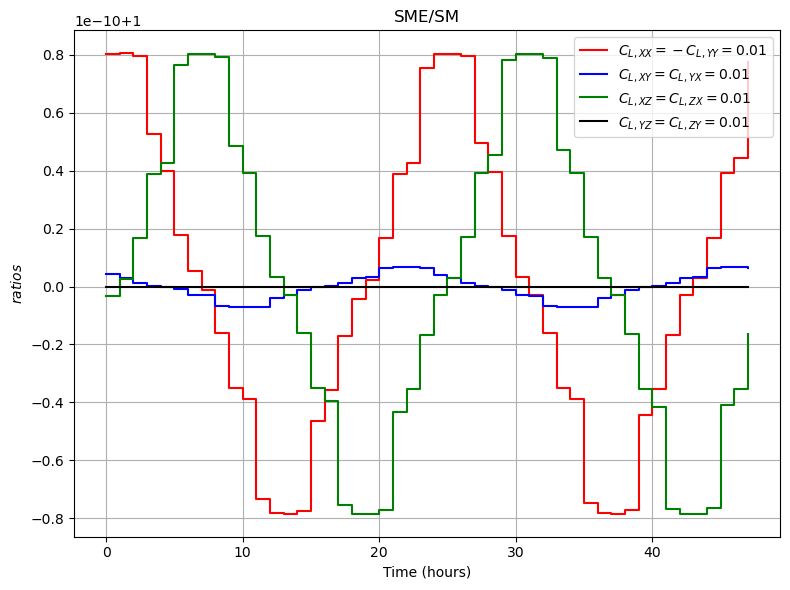

In [6]:
dratio1l = [t/resultssm[0] for t in resultssme1]
dratio2l = [t/resultssm[0] for t in resultssme2]
dratio3l = [t/resultssm[0] for t in resultssme3]
dratio4l = [t/resultssm[0] for t in resultssme4]
dratio1 = np.array(dratio1l, dtype=np.float64)
dratio2 = np.array(dratio2l, dtype=np.float64)
dratio3 = np.array(dratio3l, dtype=np.float64)
dratio4 = np.array(dratio4l, dtype=np.float64)
hours_array = np.array(hours_start, dtype=np.float64)

# Plot all data on one plot
plt.figure(figsize=(8, 6))

# Plot data
plt.step(hours_array, dratio1, where='post', color='r', label='$C_{L,XX} = - C_{L,YY} = 0.01$')
plt.step(hours_array, dratio2, where='post', color='b', label='$C_{L,XY} = C_{L,YX} = 0.01$')
plt.step(hours_array, dratio3, where='post', color='g', label='$C_{L,XZ} = C_{L,ZX} = 0.01$')
plt.step(hours_array, dratio4, where='post', color='black', label='$C_{L,YZ} = C_{L,ZY} = 0.01$')

# Add titles and labels
plt.title('SME/SM')
plt.xlabel('Time (hours)')
plt.ylabel('$ratios$')
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

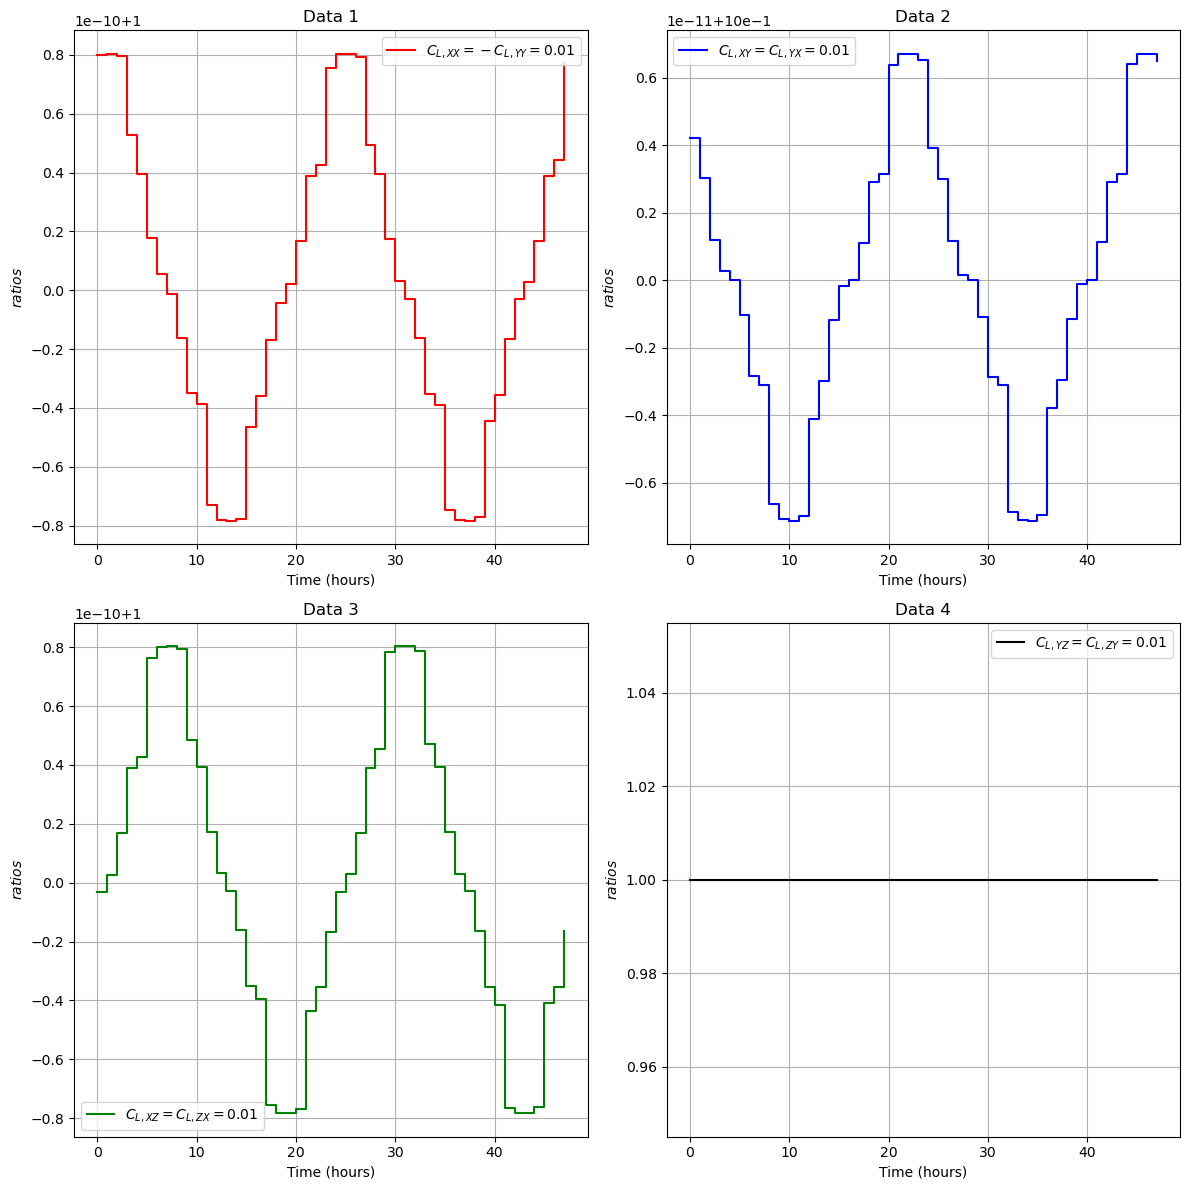

In [7]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot data in each subplot
axs[0, 0].step(hours_array, dratio1, where='post', color='r', label='$C_{L,XX} = - C_{L,YY} = 0.01$')
axs[0, 0].set_title('Data 1')
axs[0, 0].set_xlabel('Time (hours)')
axs[0, 0].set_ylabel('$ratios$')
axs[0, 0].grid(True)
axs[0, 0].legend()

axs[0, 1].step(hours_array, dratio2, where='post', color='b', label='$C_{L,XY} = C_{L,YX} = 0.01$')
axs[0, 1].set_title('Data 2')
axs[0, 1].set_xlabel('Time (hours)')
axs[0, 1].set_ylabel('$ratios$')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].step(hours_array, dratio3, where='post', color='g', label='$C_{L,XZ} = C_{L,ZX} = 0.01$')
axs[1, 0].set_title('Data 3')
axs[1, 0].set_xlabel('Time (hours)')
axs[1, 0].set_ylabel('$ratios$')
axs[1, 0].grid(True)
axs[1, 0].legend()

axs[1, 1].step(hours_array, dratio4, where='post', color='black', label='$C_{L,YZ} = C_{L,ZY} = 0.01$')
axs[1, 1].set_title('Data 4')
axs[1, 1].set_xlabel('Time (hours)')
axs[1, 1].set_ylabel('$ratios$')
axs[1, 1].grid(True)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()